In [1]:
from google.colab import drive
drive.mount('/content/drive')
 
%matplotlib inline
%matplotlib notebook

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.ndimage as ndimage
import os
import time
import json
import re
import string
from sortedcontainers import SortedDict
import nltk
from scipy.sparse import csr_matrix, lil_matrix, dok_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import scipy
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
%matplotlib inline
plt.close('all')
%cd drive/My\ Drive/ANLP/A1/submission
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ANLP/A1/submission
/content/drive/My Drive/ANLP/A1/submission


### Load the saved vocabulary and keep only those words which have frequency > 5

In [2]:
with open('unique_words.json', 'r') as pf:
    unique_words_dict = json.load(pf)

print(len(unique_words_dict))

unique_words_dict = {key:val for key, val in unique_words_dict.items() if val > 5}
print(len(unique_words_dict))


378343
69720


### Map words to index and vice versa

In [3]:
word2index = {w:idx for idx, w in enumerate(unique_words_dict)}
index2word = {idx:w for idx, w in enumerate(unique_words_dict)}

total_words = len(word2index)
print(total_words)
print(word2index["very"])
print(index2word[65873])

69720
65873
very


### Set window size and initialize Co-occurence matrix using Scipy's DOK matrix (as it supports faster incremental updates)

In [4]:
window_size = 4  ## wleft center wright
co_matrix = dok_matrix((total_words, total_words), dtype=np.float)
print(co_matrix.shape)
print(type(co_matrix))
print(co_matrix.sum())

(69720, 69720)
<class 'scipy.sparse.dok.dok_matrix'>
0.0


### Create the co-occurence matrix using the pre-processed sentences from reviews and save the matrix

In [ ]:
with open('processed_reviews.txt') as prf:
    a = 0
    for line in prf:
        words = [w for w in line.strip().split() if w in word2index]
        if len(words) <= 1:
            continue
        for i, word in enumerate(words):
            for i in range(i+1, min(i+window_size+1, len(words))):
                idx = word2index[word]
                co_matrix[idx, word2index[words[i]]] += 1
        print(a)
        a += 1

print(co_matrix.shape)
co_matrix = co_matrix.tocsr()  ## as CSR matrix supports faster arithmetic oparations
co_matrix += co_matrix.transpose() ## as co-occurence matrix is symmetric

print(type(co_matrix))
print(co_matrix.shape)

scipy.sparse.save_npz('sparse_co_matrix_csr.npz', co_matrix) 

Streaming output truncated to the last 5000 lines.
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437

KeyboardInterrupt: ignored

### Load the saved co-occurence matrix

In [5]:
co_matrix = scipy.sparse.load_npz('sparse_co_matrix_csr.npz')
print(type(co_matrix))
print(co_matrix.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(69720, 69720)


### Use Scipy's SVD function to get the new truncated word embeddings of length 64

In [6]:
k = 64
u, s, vt = scipy.sparse.linalg.svds(co_matrix, k=k)
print(u.shape, s.shape, vt.shape)
new_embeds = u 

(69720, 64) (64,) (64, 69720)


### Function to find N most similar words from the vocabulary using cosine similarity measure

In [7]:
def cosine_sim_mat(word, n=11):
    idx = word2index[word]
    cos_sim_mat = cosine_similarity(np.expand_dims(new_embeds[idx,:], axis=0), new_embeds).squeeze(0)
    similar_idx = np.argpartition(a=cos_sim_mat, kth=-n, axis=0)[-n:]
    similar_words = []
    for i in similar_idx:
        similar_words.append(index2word[i])
    return similar_words


### Find 10 most similar words for 'camera' using our SVD model as well as pre-trained word2vec model and compare the results

In [8]:
sim_words = cosine_sim_mat("camera")
print("SVD : Words similar to 'camera' are :",sim_words)

from gensim.models import KeyedVectors
w_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True, limit=10000)
print("\nWord2Vec : Words similar to 'camera' are :")
similars = w_vectors.similar_by_word('camera',topn=10)
print(similars)

SVD : Words similar to 'camera' are : ['telescope', 'hu', 'dolly', 'gps', 'detector', 'camera', 'pj', 'scope', 'cam', 'lens', 'lense']

Word2Vec : Words similar to 'camera' are :
[('cameras', 0.8131939172744751), ('video', 0.5126093626022339), ('pictures', 0.507061779499054), ('footage', 0.5013402700424194), ('photography', 0.48832467198371887), ('photograph', 0.47180312871932983), ('photos', 0.47027167677879333), ('images', 0.47022396326065063), ('photo', 0.4626350402832031), ('photographer', 0.45725348591804504)]


### Plot similar words using TSNE for different categories of words (noun, verb, adjective)


Words similar to : person
['prototype', 'woman', 'designer', 'person', 'doorway', 'seasoned', 'purchaser', 'handler', 'singer', 'dreamer', 'weirdo']

Words similar to : camera
['telescope', 'hu', 'dolly', 'gps', 'detector', 'camera', 'pj', 'scope', 'cam', 'lens', 'lense']

Words similar to : floor
['slopes', 'fritz', 'roof', 'treadmill', 'bandwagon', 'pavement', 'bringin', 'fly', 'floor', 'leppard', 'carpet']

Words similar to : truck
['acura', 'dodge', 'tacoma', 'estimation', 'camry', 'forester', 'cherokee', 'silverado', 'civic', 'truck', 'jeep']

Words similar to : television
['blog', 'property', 'phone', 'hdtv', 'computer', 'comp', 'tv', 'pc', 'monitor', 'television', 'network']

Words similar to : mounting
['radiator', 'fastening', 'handgrip', 'wasd', 'sizing', 'faceplate', 'backplate', 'attachment', 'binding', 'mounting', 'icade']

Words similar to : pull
['errored', 'figure', 'shorting', 'carve', 'flatten', 'drown', 'pull', 'swap', 'straighten', 'fizzled', 'pulled']

Words simil

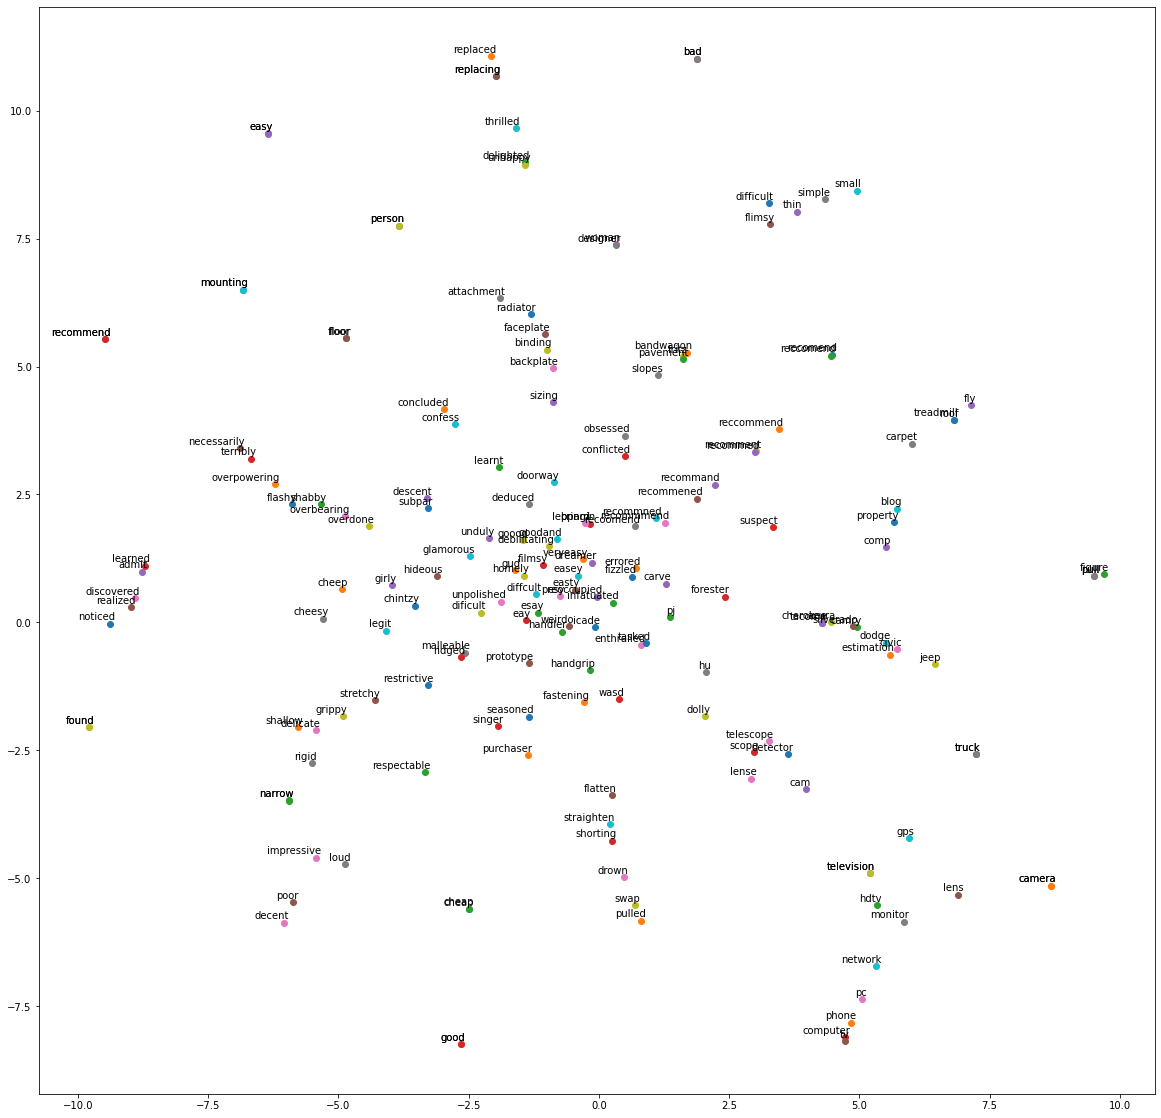

In [ ]:
def tsne_plot(words_toplot):
    labels = words_toplot.copy()
    for wp in words_toplot:
        print("\nWords similar to :",wp)
        print(cosine_sim_mat(wp))
        labels.extend(cosine_sim_mat(wp))
    tokens = []
    for lab in labels:
        idx = word2index[lab]
        tokens.append(new_embeds[idx])
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=600, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1]) 
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

words_toplot = ['person', 'camera', 'floor', 'truck', 'television', 'mounting', 'pull', 'replacing', 'found', 'recommend', 'cheap', 'good', 'narrow', 'bad', 'easy']
tsne_plot(words_toplot)